In [6]:
#Librerías principales
import os, sys
import pandas as pd
import numpy as np
import joblib

#Librerías de ML
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score, classification_report

#Ajustar path para importar desde src (subir un nivel desde notebooks/)
sys.path.append(os.path.abspath(os.path.join("..", "src")))

#Módulos propios
from data_loader import cargar_dataset, dividir_dataset
from preprocessing import preparar_texto, preparar_labels
from train import baseline_train
from evaluate import evaluar_modelo
from utils import semilla

#Configuración de semilla
semilla(42)


In [8]:
#Cargar dataset ya preprocesado
df = pd.read_csv("../data/dataset_prepared.csv")

#Dividir en train, validación y test
train_df, val_df, test_df = dividir_dataset(df, test_size=0.2, val_size=0.1, random_state=42)

In [9]:
#Textos como listas
X_train_text = preparar_texto(train_df).to_list()
X_val_text   = preparar_texto(val_df).to_list()
X_test_text  = preparar_texto(test_df).to_list()

#Etiquetas multilabel
y_train, mlb = preparar_labels(train_df)
y_val  = mlb.transform(val_df["group"].astype(str).apply(lambda x: x.split("|")))
y_test = mlb.transform(test_df["group"].astype(str).apply(lambda x: x.split("|")))

In [ ]:
#Cargar modelo pre-entrenado
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

#Embeddings (vectores densos)
X_train = embedder.encode(X_train_text, convert_to_numpy=True, show_progress_bar=True, batch_size=64)
X_val   = embedder.encode(X_val_text,   convert_to_numpy=True, show_progress_bar=True, batch_size=64)
X_test  = embedder.encode(X_test_text,  convert_to_numpy=True, show_progress_bar=True, batch_size=64)

#Revisar dimensiones
X_train.shape, X_val.shape, X_test.shape

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\lualm\OneDrive\Documentos\GitHub\Biomedical-Classification-Challenge\biomedical-classification\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lualm\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
# Entrenar modelo clásico (Logistic Regression OneVsRest)
modelo_emb = baseline_train(X_train, y_train)

In [ ]:
# Predicciones en validación
P_val = modelo_emb.predict_proba(X_val)

# Buscar umbrales por clase maximizando F1
ts = np.linspace(0.2, 0.8, 25)
best_t = []

for j in range(P_val.shape[1]):
    f1s = [f1_score(y_val[:, j], (P_val[:, j] >= t).astype(int)) for t in ts]
    best_t.append(ts[int(np.argmax(f1s))])

print("Mejores umbrales por clase:", best_t)

In [ ]:
# Predicciones en test con umbrales optimizados
P_test = modelo_emb.predict_proba(X_test)
y_pred_test = (P_test >= np.array(best_t)).astype(int)

# Garantizar al menos 1 etiqueta por muestra
rows_no_label = y_pred_test.sum(axis=1) == 0
y_pred_test[rows_no_label, np.argmax(P_test[rows_no_label], axis=1)] = 1

# Métricas
print("F1 micro:", f1_score(y_test, y_pred_test, average="micro"))
print("F1 macro:", f1_score(y_test, y_pred_test, average="macro"))
print(classification_report(y_test, y_pred_test, target_names=mlb.classes_))

Mejores umbrales por clase: [np.float64(0.55), np.float64(0.5), np.float64(0.4750000000000001), np.float64(0.37500000000000006)]


In [ ]:
# Evaluar en validación y test usando nuestra función
_ = evaluar_modelo(modelo_emb, X_val, y_val, mlb, show_plots=True, save_path="../evidence/embeddings_val")
_ = evaluar_modelo(modelo_emb, X_test, y_test, mlb, show_plots=True, save_path="../evidence/embeddings_test")

In [ ]:
# Guardar modelo, vectorizador y binarizador
joblib.dump(modelo_emb, "../models/embeddings_logreg.joblib")
joblib.dump(embedder, "../models/sentence_transformer.joblib")
joblib.dump(mlb, "../models/labels_mlb_embeddings.joblib")

F1 micro: 0.8361018826135105
F1 macro: 0.8322944875911673
                precision    recall  f1-score   support

cardiovascular       0.88      0.80      0.84       254
   hepatorenal       0.92      0.76      0.83       217
  neurological       0.85      0.84      0.84       358
   oncological       0.91      0.74      0.82       120

     micro avg       0.88      0.80      0.84       949
     macro avg       0.89      0.78      0.83       949
  weighted avg       0.88      0.80      0.84       949
   samples avg       0.91      0.86      0.86       949



In [ ]:
####opcional





#

Exact Match Ratio: 0.6923
F1 Micro: 0.8515
F1 Macro: 0.8398

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.94      0.81      0.87       102
   hepatorenal       0.90      0.75      0.82        87
  neurological       0.90      0.85      0.87       142
   oncological       0.94      0.69      0.80        48

     micro avg       0.92      0.79      0.85       379
     macro avg       0.92      0.77      0.84       379
  weighted avg       0.92      0.79      0.85       379
   samples avg       0.92      0.85      0.87       379



/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


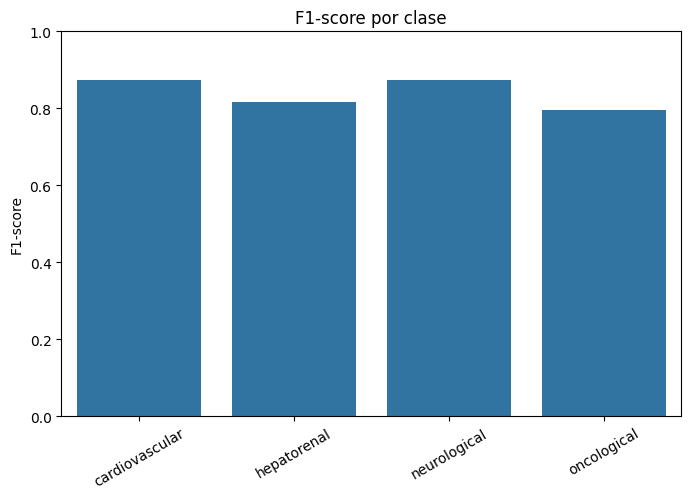

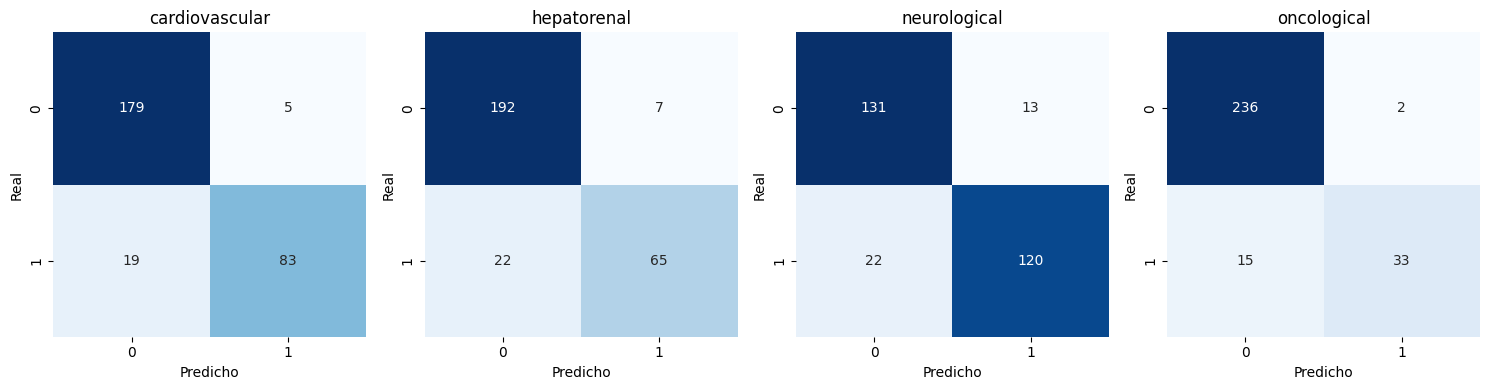

Exact Match Ratio: 0.6550
F1 Micro: 0.8399
F1 Macro: 0.8289

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.86      0.83      0.85       254
   hepatorenal       0.93      0.75      0.83       217
  neurological       0.89      0.83      0.86       358
   oncological       0.96      0.66      0.78       120

     micro avg       0.90      0.79      0.84       949
     macro avg       0.91      0.77      0.83       949
  weighted avg       0.90      0.79      0.84       949
   samples avg       0.91      0.85      0.86       949



/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juanfe321/Desktop/AGARIANDOREMANDO/Biomedical-Classification-Challenge/biomedical-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


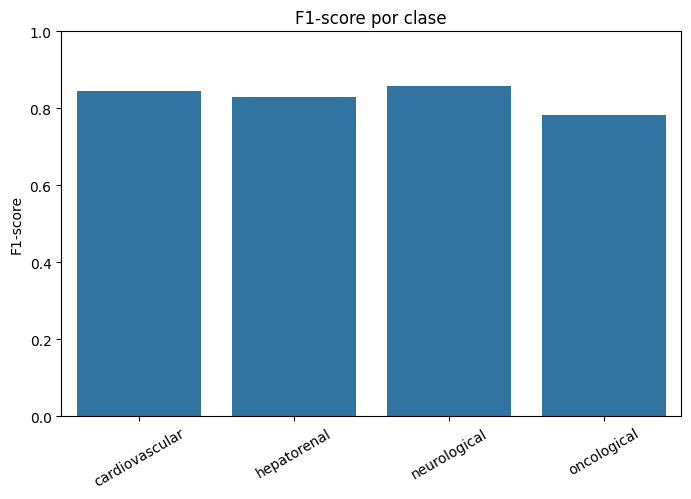

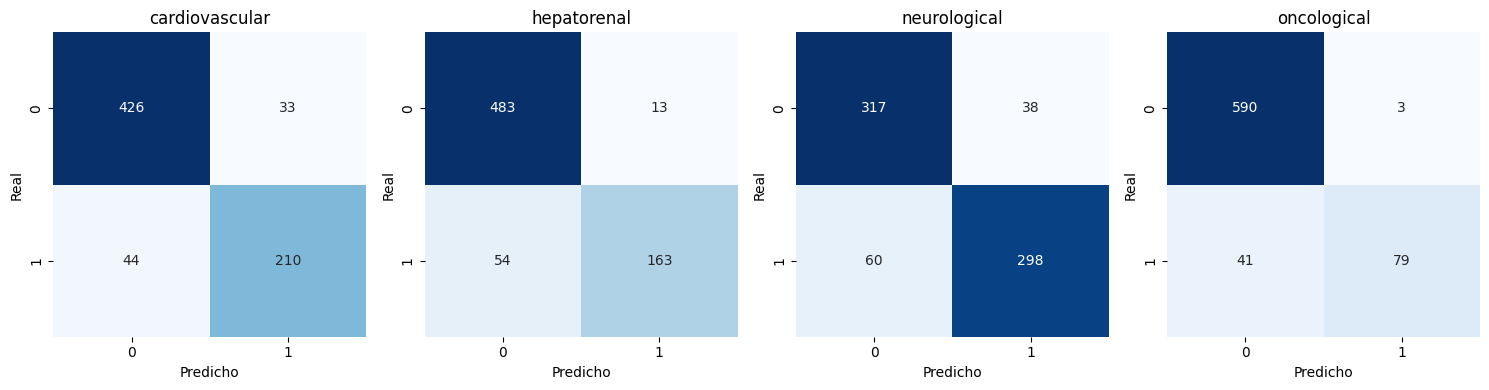

In [ ]:
#evaluar
metrics_val = evaluar_modelo(
    modelo_emb,
    X_val,
    y_val,
    mlb,
    nombre_modelo="embeddings",
    split="val",
    show_plots=True,
    save_path="../evidence/embeddings_val"
)

metrics_test = evaluar_modelo(
    modelo_emb,
    X_test,
    y_test,
    mlb,
    nombre_modelo="embeddings",
    split="test",
    show_plots=True,
    save_path="../evidence/embeddings_test"
)


In [ ]:
#GUARDAR
joblib.dump(modelo_emb, "../models/embeddings_logreg.joblib")
joblib.dump(embedder, "../models/sentence_transformer.joblib")
joblib.dump(mlb, "../models/labels_mlb_embeddings.joblib")

['../models/labels_mlb_embeddings.joblib']